In [1]:
import matplotlib.pyplot as plt
import numpy as np
from flow_policy.flow_policy import FlowPolicy

from pydrake.all import (
    CompositeTrajectory,
    PiecewisePolynomial,
    Trajectory,
)


In [2]:
def demonstration_traj_right() -> Trajectory:
    """
    Returns a trajectory x(t) that is 0 for 0 < t < 0.25, and a sine curve
    for 0.25 < t < 1 that starts at 0 and ends at 0.75.
    """
    piece_1 = PiecewisePolynomial.FirstOrderHold(
        breaks=[0, 0.25],
        samples=[[0, 0]],
    )
    piece_2 = PiecewisePolynomial.CubicWithContinuousSecondDerivatives(
        breaks=[0.25, 0.50, 0.75, 1.0],
        samples=[[0.00, 0.62, 0.70, 0.5]],
        sample_dot_at_start=[[0.0]],
        sample_dot_at_end=[[-0.7]],
    )
    return CompositeTrajectory([piece_1, piece_2])

def demonstration_traj_left() -> Trajectory:
    """
    Returns a trajectory x(t) that is 0 for 0 < t < 0.25, and a sine curve
    for 0.25 < t < 1 that starts at 0 and ends at 0.75.
    """
    piece_1 = PiecewisePolynomial.FirstOrderHold(
        breaks=[0, 0.25],
        samples=[[0, 0]],
    )
    piece_2 = PiecewisePolynomial.CubicWithContinuousSecondDerivatives(
        breaks=[0.25, 0.50, 0.75, 1.0],
        samples=[[0.00, -0.62, -0.70, -0.5]],
        sample_dot_at_start=[[0.0]],
        sample_dot_at_end=[[0.7]],
    )
    return CompositeTrajectory([piece_1, piece_2])

traj_right = demonstration_traj_right()
traj_left = demonstration_traj_left()

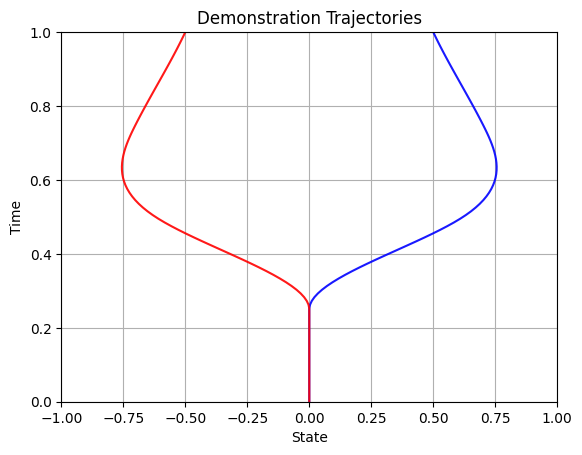

In [3]:
"""
Plot demonstration trajectory on x-y plane where x axis is the state in [-1, 1]
and y axis is the time in [0, 1].
"""
times = np.linspace(0, 1, 100)
plt.plot(traj_right.vector_values(times)[0], times, color='blue', alpha=0.9)
plt.plot(traj_left.vector_values(times)[0], times, color='red', alpha=0.9)
plt.xlim(-1, 1)
plt.ylim(0, 1)
plt.xlabel('State')
plt.ylabel('Time')
plt.title('Demonstration Trajectories')
plt.grid(True)
plt.show()

## Conditional flow

In [4]:
fp = FlowPolicy(trajectories=[traj_right], prior=[1.0], sigma=0.05)

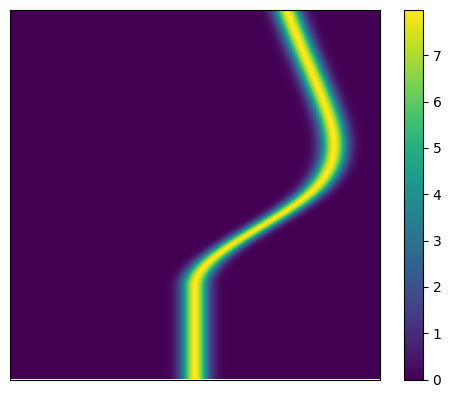

In [5]:
ts = np.linspace(0, 1, 200)  # (T,)
xs = np.linspace(-1, 1, 200)  # (X,)
ts, xs = np.meshgrid(ts, xs, indexing='ij')  # (T, X)
p = fp.pdf_marginal(xs, ts)  # (T, X)
plt.imshow(p, origin='lower')
plt.colorbar()
plt.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)
# plt.tight_layout()
plt.show()


## Plotting code

In [6]:
def plot_probability_density_and_vector_field(fp, ax, num_points=200, num_quiver=20):
    ts = np.linspace(0, 1, num_points)  # (T,)
    xs = np.linspace(-1, 1, num_points)  # (X,)
    ts, xs = np.meshgrid(ts, xs, indexing='ij')  # (T, X)
    p = fp.pdf_marginal(xs, ts)  # (T, X)
    u = fp.u_marginal(xs, ts)  # (T, X)

    # Plot probability density
    heatmap = ax.imshow(p, origin='lower', extent=[-1, 1, 0, 1], aspect='auto', alpha=1)

    # Plot quiver with reduced size
    quiver_step_x = xs.shape[1] // num_quiver
    quiver_step_t = ts.shape[0] // num_quiver
    ax.quiver(
        xs[::quiver_step_t, ::quiver_step_x],
        ts[::quiver_step_t, ::quiver_step_x], 
        u[::quiver_step_t, ::quiver_step_x],
        np.ones_like(u)[::quiver_step_t, ::quiver_step_x], 
        color='white', scale=40, width=0.002, headwidth=3, headlength=4
    )

    ax.set_xlim(-1, 1)
    ax.set_ylim(0, 1)
    ax.set_title('Probability Density and Vector Field')
    ax.set_xlabel('State')
    ax.set_ylabel('Time ⟶')

    ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)

    return heatmap

# Example of how to call the function:
# fig, ax = plt.subplots(figsize=(5, 4), dpi=300)
# im = plot_probability_density_and_vector_field(fp, ax)
# plt.colorbar(im, ax=ax, label='Probability Density')
# plt.show()


In [7]:
def plot_probability_density_and_streamlines(fp, ax, num_points=400):
    ts = np.linspace(0, 1, num_points)  # (T,)
    xs = np.linspace(-1, 1, num_points)  # (X,)
    ts, xs = np.meshgrid(ts, xs, indexing='ij')  # (T, X)
    p = fp.pdf_marginal(xs, ts)  # (T, X)
    u = fp.u_marginal(xs, ts)  # (T, X)

    # Plot log probability
    im = ax.imshow(p, origin='lower', extent=[-1, 1, 0, 1], aspect='auto', alpha=1)

    # Plot streamlines
    ax.streamplot(x=xs[0], y=ts[:, 0], u=u, v=np.ones_like(u), 
                  color='white', density=1, linewidth=0.5, arrowsize=0.5)

    ax.set_xlim(-1, 1)
    ax.set_ylim(0, 1)
    ax.set_title('Probability Density and Flow')
    ax.set_xlabel('State')
    ax.set_ylabel('Time ⟶')

    ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)

    return im

# Example of how to call the function:
# fig, ax = plt.subplots(figsize=(6, 4), dpi=300)
# im = plot_probability_density_and_streamlines(fp, ax)
# plt.colorbar(im, ax=ax, label='Probability Density')
# plt.show()



## Plot vector field

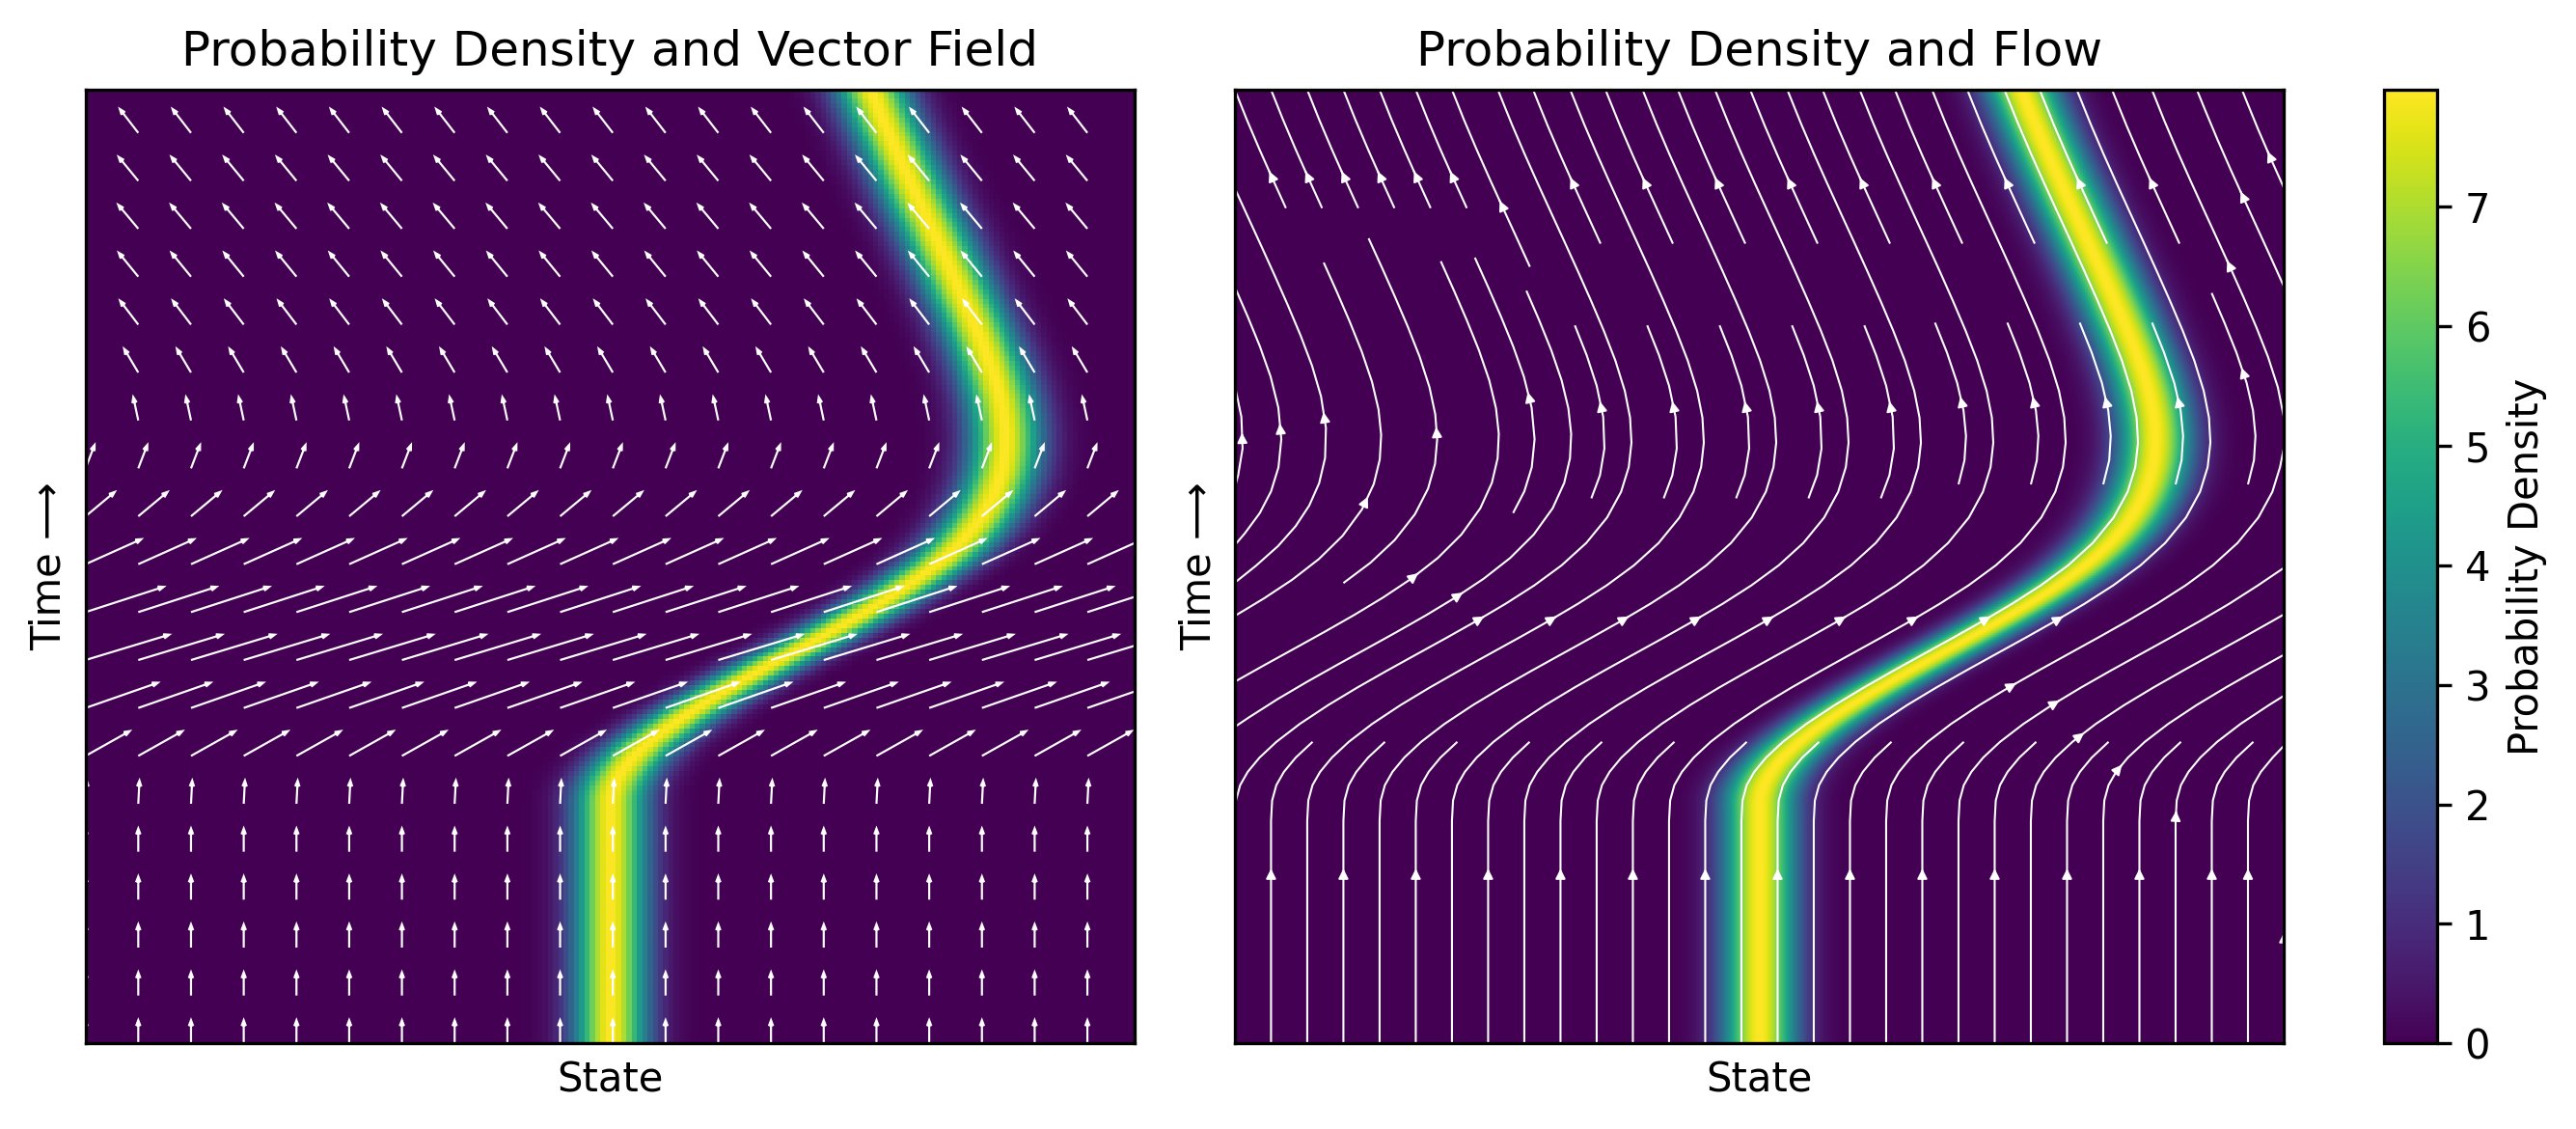

In [8]:
fig = plt.figure(figsize=(9, 4), dpi=300)
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.05])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
im1 = plot_probability_density_and_vector_field(fp, ax1)
im2 = plot_probability_density_and_streamlines(fp, ax2)
plt.colorbar(im2, cax=ax3, label='Probability Density')
plt.tight_layout()  # Uncommented to adjust spacing
plt.show()

## Marginal flow

In [9]:
fp = FlowPolicy(trajectories=[traj_right, traj_left], prior=[0.5, 0.5], sigma=0.05)

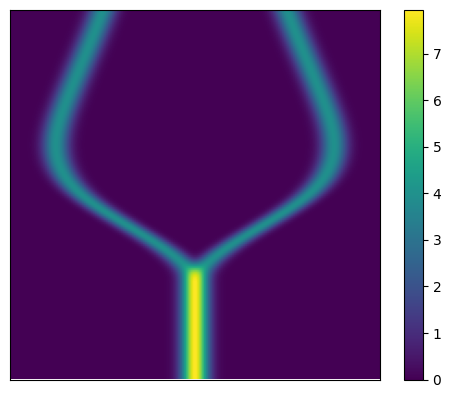

In [10]:
ts = np.linspace(0, 1, 200)  # (T,)
xs = np.linspace(-1, 1, 200)  # (X,)
ts, xs = np.meshgrid(ts, xs, indexing='ij')  # (T, X)
p = fp.pdf_marginal(xs, ts)  # (T, X)
plt.imshow(p, origin='lower')
plt.colorbar()
plt.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)
# plt.tight_layout()
plt.show()


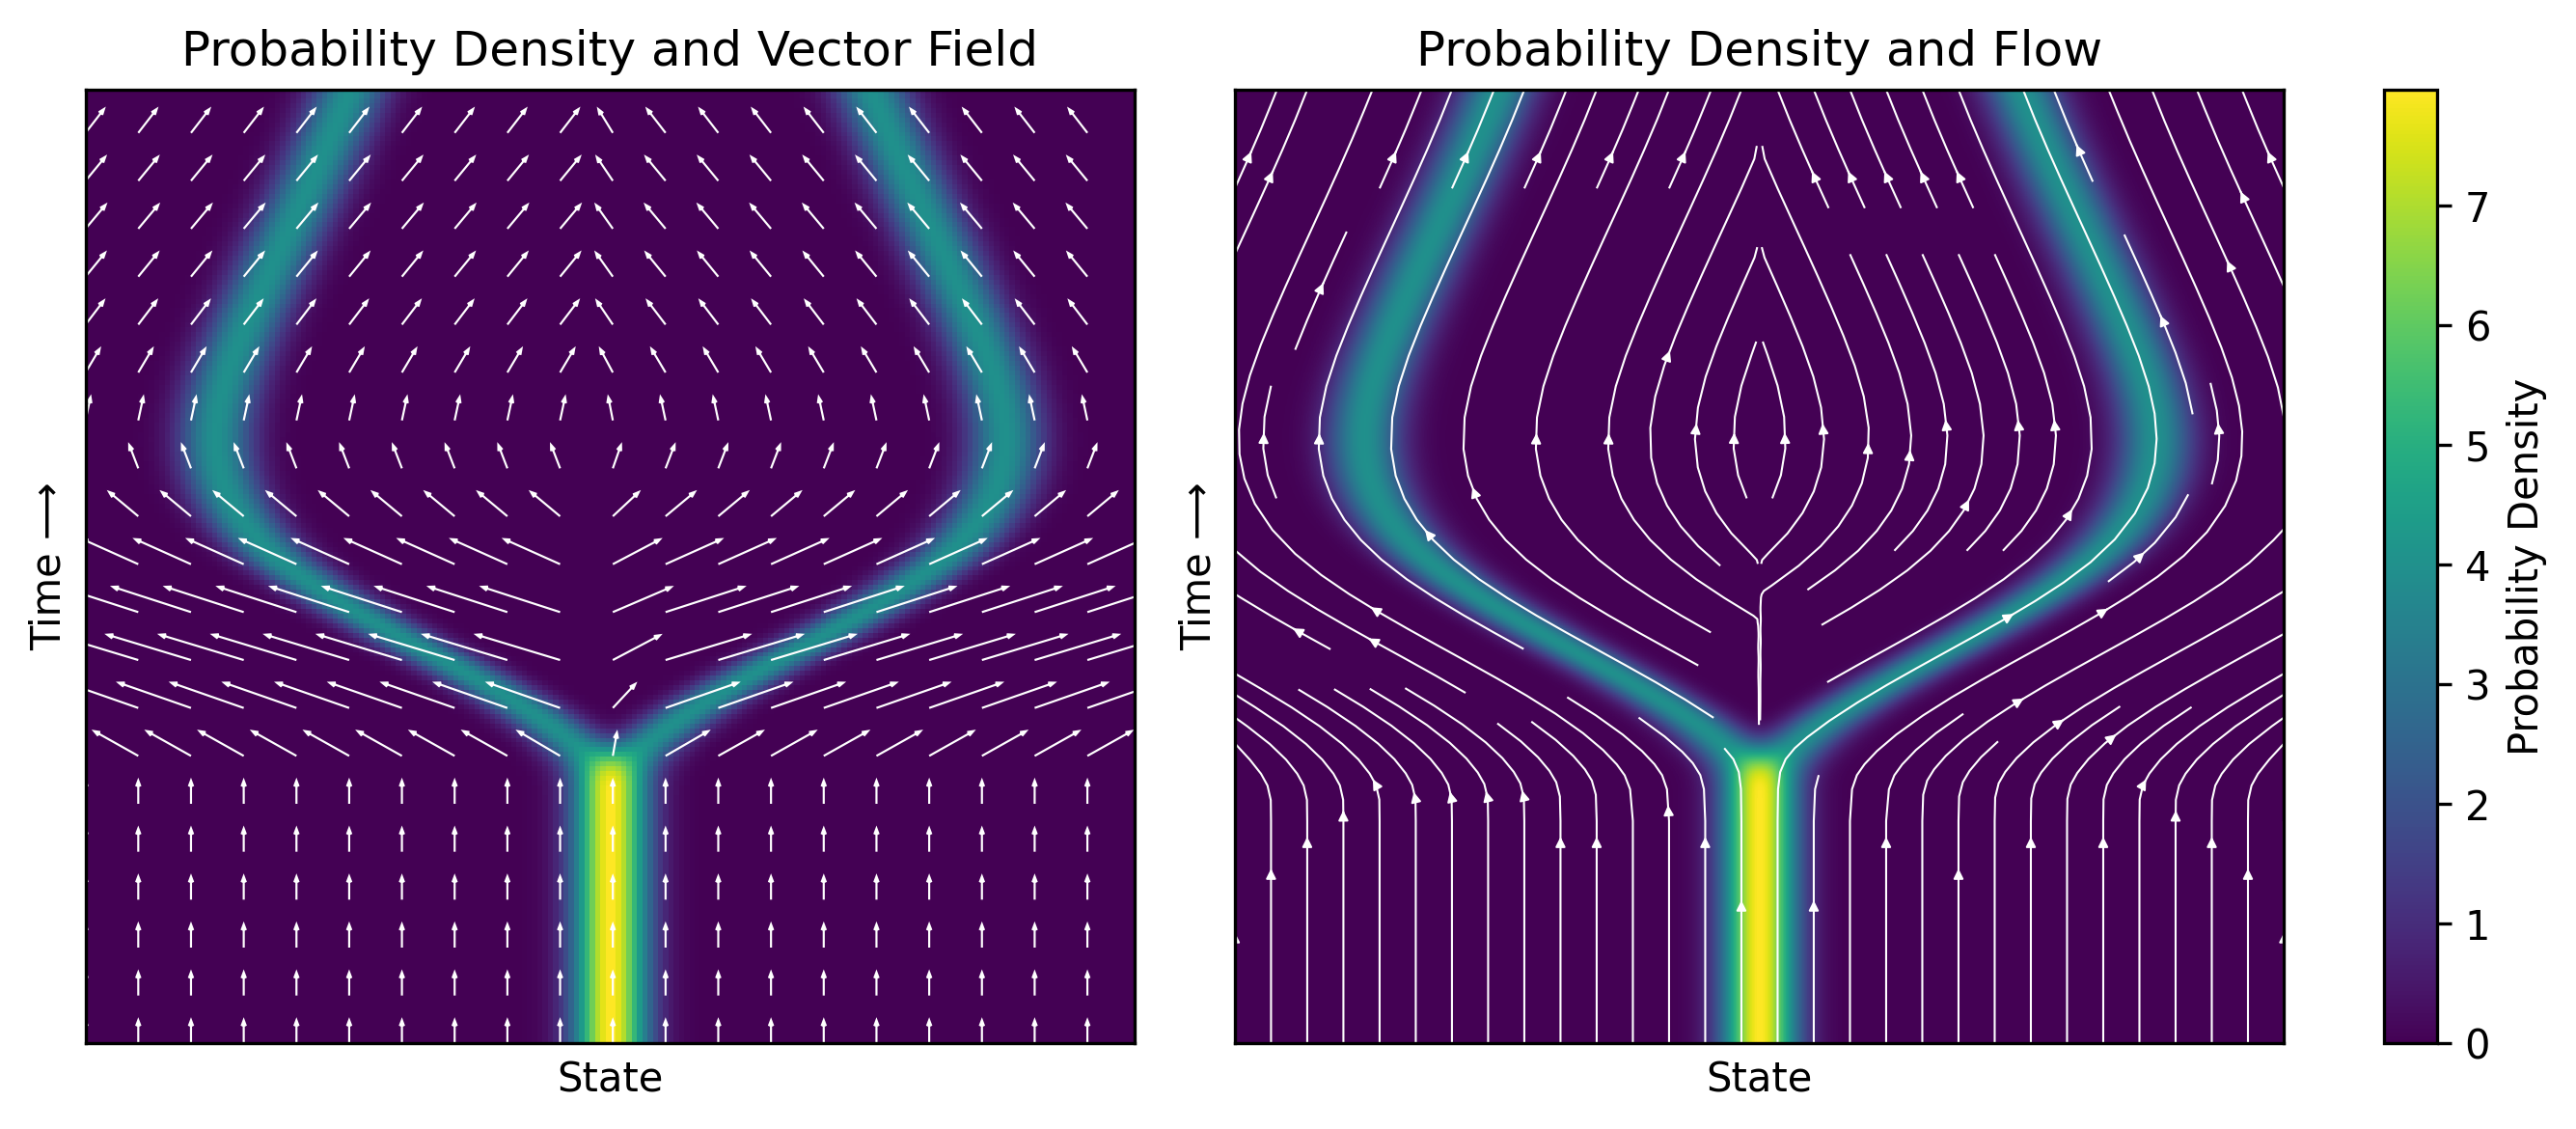

In [11]:
fig = plt.figure(figsize=(9, 4), dpi=300)
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 0.05])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
im1 = plot_probability_density_and_vector_field(fp, ax1)
im2 = plot_probability_density_and_streamlines(fp, ax2)
plt.colorbar(im2, cax=ax3, label='Probability Density')
plt.tight_layout()  # Uncommented to adjust spacing
plt.show()